In [1]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../utils/")
sys.path.append("../")
from torch.utils.data import DataLoader
from utils import MyDataset, Normalize
from tqdm import tqdm
from networks.allaire_net import Allaire_Net
from networks.conv_net import Conv_Net
from networks.conv_net_2 import Conv_Net2
from networks.unet import U_Net
from networks.utils import EarlyStopper
import json
import argparse
import os
import pathlib
import numpy.ma as ma
import csv

In [2]:
transform = Normalize(root="../../data")
dataset = MyDataset(root="../../data", tform=transform)
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [3]:
fuel_t = {}
with open('./spain_lookup_table.csv', mode='r') as infile:
    reader = csv.reader(infile)
    i = 0
    for row in reader:
        fuel_t[row[0]] = row[3]
        i+=1
fuel_t['141'] = 'Non-fuel'
f = open('./biomass.json')
biomass_t = json.load(f)
f.close()

In [4]:
biomass_t['Non-fuel']= {"1-hr": 0.0,
                        "10-hr": 0.0,
                        "100-hr": 0.0,
                        "Live Herb": 0.0}

In [5]:
intervals = ["5", "10", "20"]
fuels = {}
arqueo = {}
cbd = {}
cbh = {}
elevation = {}
flora = {}
paleo = {}
urban = {}
total_biomass = {}
canopy_biomass = {}
fine_biomass = {}
live_herb = {}
for i in intervals:
    fuels[i] = []
    arqueo[i] = []
    cbd[i] = []
    cbh[i] = []
    elevation[i] = []
    flora[i] = []
    paleo[i] = []
    urban[i] = []
    importance = 0.7
    FOLDER = pathlib.Path(f"./attention_maps/{i}")
    for item in tqdm(FOLDER.iterdir()):
        fire_number = item.name.split("-")[0]
        file = np.load(f'../../data/backgrounds_400/background_{fire_number}.npz')
        topology = np.concatenate([np.expand_dims(file["a1"], axis=0), np.expand_dims(file["a2"], axis=0), np.expand_dims(file["a3"], axis=0)
                                    , np.expand_dims(file["a4"], axis=0), np.expand_dims(file["a5"], axis=0), 
                                    np.expand_dims(file["a6"], axis=0), np.expand_dims(file["a7"], axis=0), 
                                    np.expand_dims(file["a8"], axis=0)])
        topology = np.where(topology == -9999.0, -1, topology)
        map = plt.imread(f"./attention_maps/{i}/{item.name}")
        filtered = np.where(map >= importance, 0, 1)
        mx = ma.masked_array(topology, mask=np.stack([filtered]*8, axis=0))
        # Biomass:
        cbd[i].append(mx[2].data[np.logical_not(mx[2].mask)].tolist())
        cbh[i].append(mx[3].data[np.logical_not(mx[3].mask)].tolist())
        fuels[i].append(mx[0].data[np.logical_not(mx[0].mask)].tolist())
        arqueo[i].append(mx[1].data[np.logical_not(mx[1].mask)].tolist())
        elevation[i].append(mx[4].data[np.logical_not(mx[0].mask)].tolist())
        flora[i].append(mx[5].data[np.logical_not(mx[5].mask)].tolist())
        paleo[i].append(mx[6].data[np.logical_not(mx[6].mask)].tolist())
    height = [(x + 1.201) / (1 - 0.391) - x for x in cbh[i][0]] # mts
    volume = 80 * 80 * height
    canopy_biomass[i] = [x * y for x, y in zip(volume, cbd[i][0])] # kilograms in 6400 m²
    canopy_biomass[i] = [x / 6400 for x in canopy_biomass[i]] # kg / m²
    canopy_biomass[i] = [x * 10 for x in canopy_biomass[i]] # ton / hect
    total_biomass[i] = [biomass_t[fuel_t[(str(int(x)))]]["1-hr"] + biomass_t[fuel_t[(str(int(x)))]]["10-hr"] + biomass_t[fuel_t[(str(int(x)))]]["100-hr"] + biomass_t[fuel_t[(str(int(x)))]]["Live Herb"] for x in fuels[i][0] if x != -1]
    fine_biomass[i] = [biomass_t[fuel_t[(str(int(x)))]]["1-hr"] + biomass_t[fuel_t[(str(int(x)))]]["10-hr"] for x in fuels[i][0] if x != -1]
    live_herb[i] = [biomass_t[fuel_t[(str(int(x)))]]["Live Herb"] for x in fuels[i][0] if x != -1]
    

6787it [02:55, 38.69it/s]
4932it [02:10, 37.80it/s]
10595it [04:55, 35.91it/s]


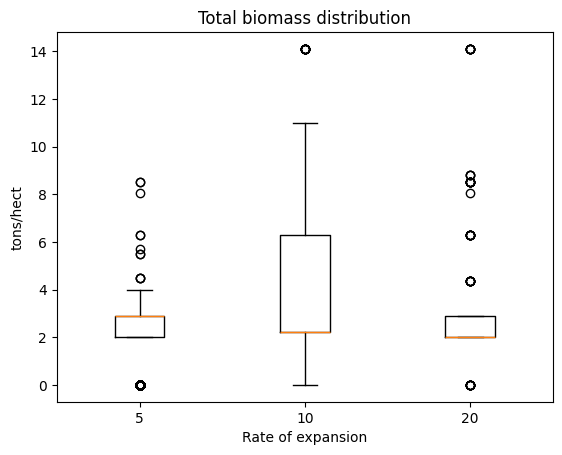

In [7]:
plt.title("Total biomass distribution")
data = [total_biomass[c] for c in intervals[:3]]
plt.boxplot(data, labels = intervals[:3])
plt.xlabel("Rate of expansion")
plt.ylabel("tons/hect")
plt.savefig("biomass/box_total_biomass.png")

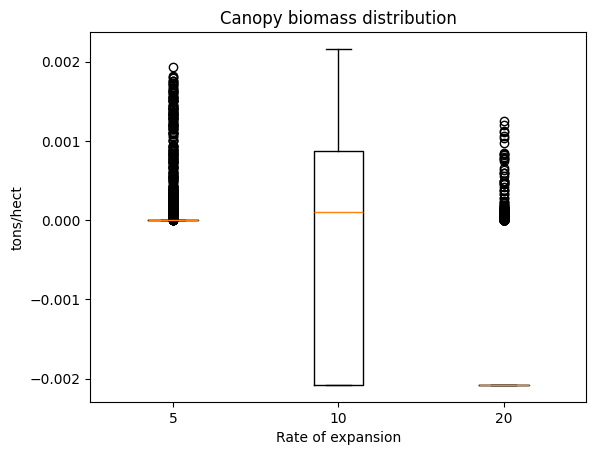

In [8]:
plt.title("Canopy biomass distribution")
data = [canopy_biomass[c] for c in intervals[:3]]
plt.boxplot(data, labels = intervals[:3])
plt.xlabel("Rate of expansion")
plt.ylabel("tons/hect")
plt.savefig("biomass/box_canopy_biomass.png")

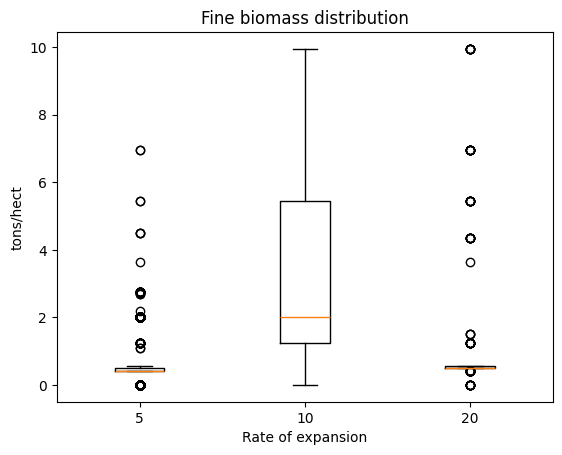

In [9]:
plt.title("Fine biomass distribution")
data = [fine_biomass[c] for c in intervals[:3]]
plt.boxplot(data, labels = intervals[:3])
plt.xlabel("Rate of expansion")
plt.ylabel("tons/hect")
plt.savefig("biomass/box_fine_biomass.png")

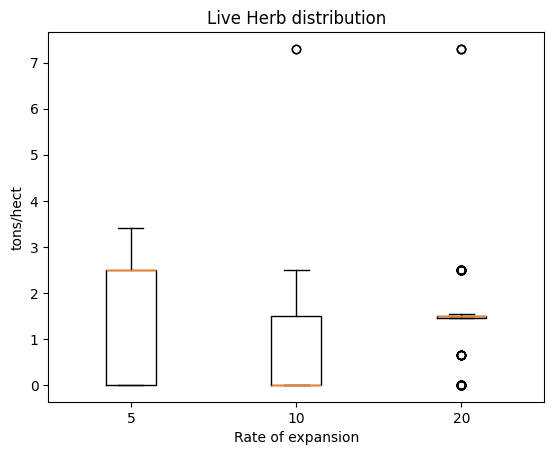

In [10]:
plt.title("Live Herb distribution")
data = [live_herb[c] for c in intervals[:3]]
plt.boxplot(data, labels = intervals[:3])
plt.xlabel("Rate of expansion")
plt.ylabel("tons/hect")
plt.savefig("biomass/box_live_herb.png")